In [18]:
import numpy as np


def smooth_filter(arr, size=5):
    """
    Apply a strict nanmean filter to a 2D array:
    - For each point, if more than one of the neighbors is NaN, return NaN.
    - Otherwise, return the nanmean of neighbors.
    
    Parameters:
        arr: 2D numpy array
        size: int, either 5 (cross-shaped) or 9 (3x3 square)
    
    Returns:
        2D numpy array with the filter applied.
    """
    arr = np.asarray(arr)
    if arr.ndim != 2:
        raise ValueError("Input array must be 2-dimensional.")
    if size not in (5, 9):
        raise ValueError("Size must be 5 or 9.")

    result = arr.copy()
    nrows, ncols = arr.shape

    for i in range(nrows):
        for j in range(ncols):
            if np.isnan(arr[i, j]):
                continue
            neighbors = []

            if size == 5:
                coords = [(i, j),
                          (i-1, j), (i+1, j),
                          (i, j-1), (i, j+1)]
            elif size == 9:
                coords = [(ii, jj)
                          for ii in range(i-1, i+2)
                          for jj in range(j-1, j+2)]

            for ii, jj in coords:
                if 0 <= ii < nrows and 0 <= jj < ncols:   #A way to deal with the borders
                    neighbors.append(arr[ii, jj])
                else:
                    neighbors.append(np.nan)

            if np.isnan(neighbors).sum() > 2:
                result[i, j] = np.nan
            else:
                result[i, j] = np.nanmean(neighbors)

    return result

In [ ]:
work_place = "ubuntu" # 'hydra', 'ubuntu' or 'win'
if work_place == 'hydra':
    base_path = r'/home/jorge.gacitua/salidas/L96_multiple_experiments/data/LETKF'
    output_dir = r'/home/jorge.gacitua/salidas/L96_multiple_experiments/figures'
elif work_place == 'ubuntu':
    base_path = r'/media/jgacitua/storage/L96_multiple_experiments/data/LETKF'
    output_dir = r'/media/jgacitua/storage/L96_multiple_experiments/figures'
elif work_place == 'win':
    base_path  = r'C:\Users\jyndd\OneDrive\Doctorado\Experimentos\L96_multiple_experiments\data\LETKF'
    output_dir = r'C:\Users\jyndd\OneDrive\Doctorado\Experimentos\L96_multiple_experiments\figures'

## Sensibilidad al Error en las Observaciones

Figure saved as: 
 PDF: /home/jorge.gacitua/salidas/L96_multiple_experiments/figures/Figure_ObsError_Sensitivity_Nens20_Freq4_Den1.0_Type3_PTemp2_NOGEC.pdf 
 PNG: /home/jorge.gacitua/salidas/L96_multiple_experiments/figures/Figure_ObsError_Sensitivity_Nens20_Freq4_Den1.0_Type3_PTemp2_NOGEC.png


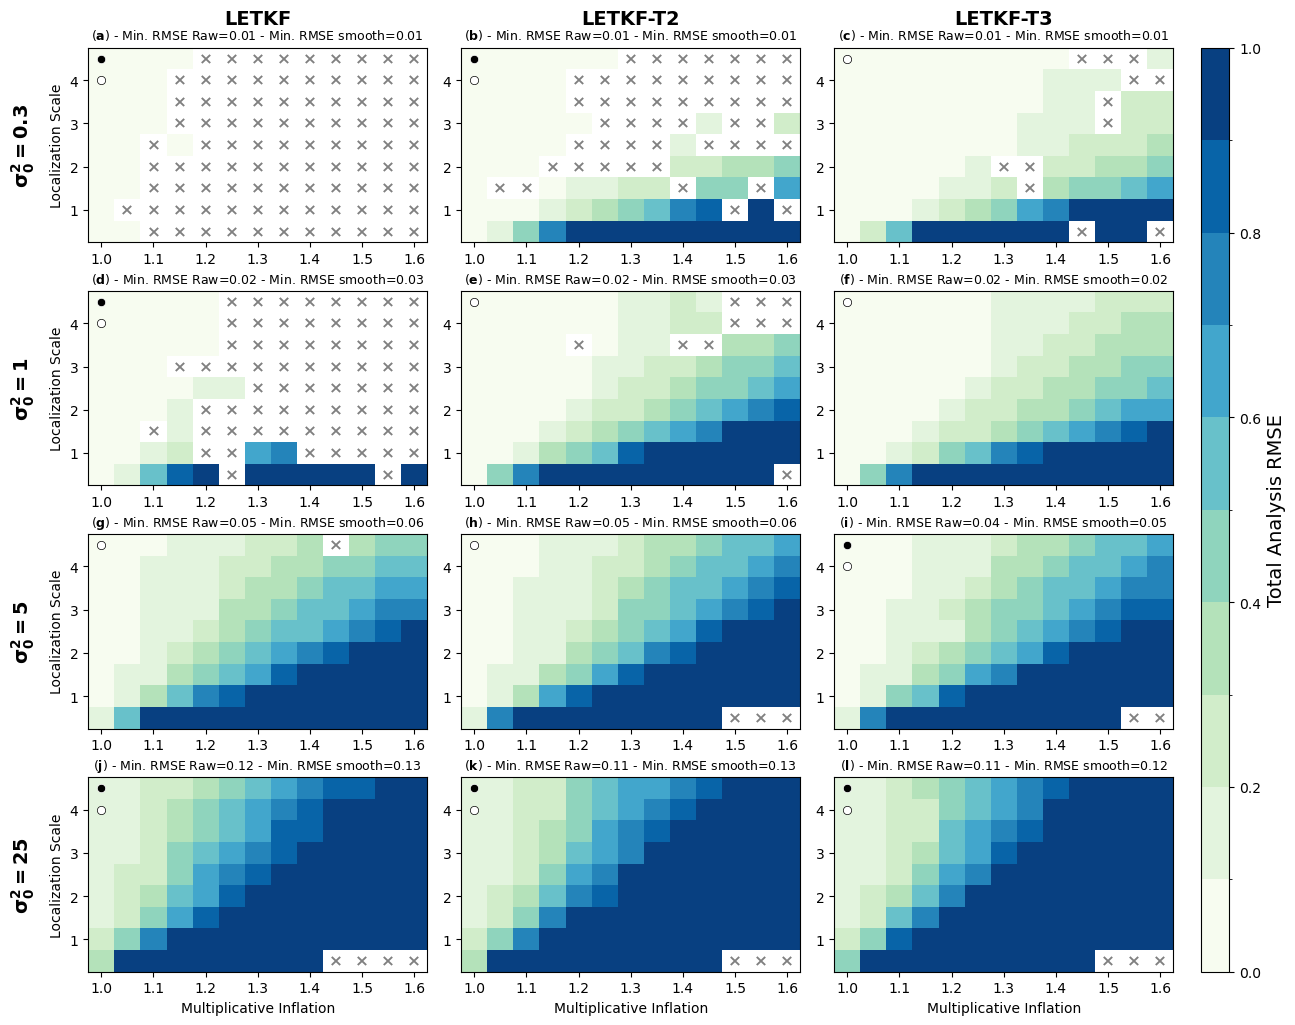

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import common_function as cf
import matplotlib.colors as mcolors
# Configuración
obs_errs = ['0.3', '1', '5', '25']
ntemps = [1, 2, 3]
labels = ['LETKF', 'LETKF-T2', 'LETKF-T3']

nens = 20
freq = 4
den = 1.0
alpha = 2
gec = '_NOGEC'
fig, axes = plt.subplots(len(obs_errs), len(ntemps), figsize=(14, 12), 
                         sharex=False, sharey=False, 
                         gridspec_kw={'hspace': 0.25, 'wspace': 0.1})


cbar_ax = fig.add_axes([0.92, 0.11, 0.02, 0.77])  # x, y, width, height

vmin, vmax = 0, 2
panel_label_counter = 0

for i, obs in enumerate(obs_errs):
    for j, ntemp in enumerate(ntemps):
        #filename = f'ORIG_LETKF_Paper_Nature_Freq{freq}_Den{den}_Type3_ObsErr{obs}_Nens20_NTemp{ntemp}{gec}.npz'
        filename = f'LETKF_Paper_Nature_Freq{freq}_Den{den}_Type3_ObsErr{obs}_Nens{nens}_NTemp{ntemp}_alpha{alpha}{gec}.npz'
        filepath = os.path.join(base_path, filename)

        ax = axes[i, j]

        if os.path.exists(filepath):
            data = np.load(filepath, allow_pickle=True)
            #results = data['results']
            mult_inf_range = data['mult_inf_range']
            loc_scale_range = data['loc_scale_range']

            rmse = data['total_analysis_rmse']
            sprd = data['total_analysis_sprd']
            NormalEnd = 1 - data['NormalEnd']
            NormalEnd = NormalEnd.astype(bool)
            rmse[NormalEnd] = np.nan
            sprd[NormalEnd] = np.nan
            rmse = cf.outlier_rmse_filter(rmse)
            ratio = rmse_smooth/ sprd_smooth
            # Apply smoothing
            rmse_smooth = smooth_filter(rmse, size=5)
            sprd_smooth = smooth_filter(sprd, size=5)
            ratio_smooth = rmse_smooth/ sprd_smooth

            #select the index closest to 1

            idx_flat = np.nanargmin(np.abs(ratio - 1))
            idx_min = np.unravel_index(idx_flat, ratio.shape)
            best_mult_inf = mult_inf_range[idx_min[0]]
            best_loc_scale = loc_scale_range[idx_min[1]]
            best_value = ratio[idx_min[0],idx_min[1]]

            idx_flat_smooth = np.nanargmin(np.abs(ratio_smooth - 1))
            idx_min_smooth = np.unravel_index(idx_flat_smooth, ratio_smooth.shape)
            best_mult_inf_smooth = mult_inf_range[idx_min_smooth[0]]
            best_loc_scale_smooth = loc_scale_range[idx_min_smooth[1]]
            best_value_smooth = ratio[idx_min_smooth[0],idx_min_smooth[1]]

            levels = np.arange(0, 1.1, 0.1)  
            norm = mcolors.BoundaryNorm(boundaries=levels, ncolors=256)

            im = ax.pcolormesh(mult_inf_range, loc_scale_range, ratio.T,
                            cmap='GnBu', norm=norm, edgecolors='lightgray', linewidth=0.001)            
            ax.plot(best_mult_inf, best_loc_scale, 'k.', markersize=12, markeredgecolor='white',markeredgewidth=0.5)
            ax.plot(best_mult_inf_smooth, best_loc_scale_smooth, 'w.', markersize=12, markeredgecolor='black',markeredgewidth=0.5)

            nan_mask = np.isnan(ratio.T)
            for (y, x), is_nan in np.ndenumerate(nan_mask):
                if is_nan:
                    xi = mult_inf_range[x]
                    yi = loc_scale_range[y]
                    ax.text(xi, yi, '×', ha='center', va='center', color='gray', fontsize=12, fontweight='bold')

            panel_label = rf"$\bf{{{chr(97 + panel_label_counter)}}}$"
            ax.set_title(f"({panel_label}) - Best Ratio raw={best_value:.2f} - Best Ratio smooth={best_value_smooth:.2f}", fontsize=7)

            panel_label_counter += 1

            if j == 0:
                ax.set_ylabel('Localization Scale', fontsize=10)
            if i == len(obs_errs) - 1:
                ax.set_xlabel('Multiplicative Inflation', fontsize=10)

for i, obs in enumerate(obs_errs):
    axes[i, 0].annotate(rf"$\bf{{\sigma^2_0 = {obs}}}$", xy=(-0.15, 0.5), xycoords='axes fraction',
                        rotation=90, va='center', ha='right', fontsize=14, weight='bold')
for j, t in enumerate(ntemps):
    axes[0, j].annotate(labels[j], xy=(0.5, 1.15), xycoords='axes fraction',
                        va='center', ha='center', fontsize=14, weight='bold')
cbar = fig.colorbar(im, cax=cbar_ax,ticks=np.arange(0, 2.2, 0.2))
cbar.set_label('Total Analysis RMSE', fontsize=14)

os.makedirs(output_dir, exist_ok=True)
figname = f"Figure_Ratio_ObsError_Sensitivity_Nens{nens}_Freq{freq}_Den{den}_Type3_PTemp{alpha}{gec}"
output_pdf = os.path.join(output_dir, f"{figname}.pdf")
output_png = os.path.join(output_dir, f"{figname}.png")

plt.savefig(output_pdf, dpi=300, bbox_inches='tight', format='pdf')
plt.savefig(output_png, dpi=300, bbox_inches='tight', format='png')
#plt.show()

print(f"Figure saved as: \n PDF: {output_pdf} \n PNG: {output_png}")

### Sensibilidad al numero de Ensambles

Figure saved as: 
 PDF: /home/jorge.gacitua/salidas/L96_multiple_experiments/figures/Figure_Nens_Sensitivity_Freq4_Den1.0_Type3_PTemp2_ObsErr5_NOGEC.pdf 
 PNG: /home/jorge.gacitua/salidas/L96_multiple_experiments/figures/Figure_Nens_Sensitivity_Freq4_Den1.0_Type3_PTemp2_ObsErr5_NOGEC.png


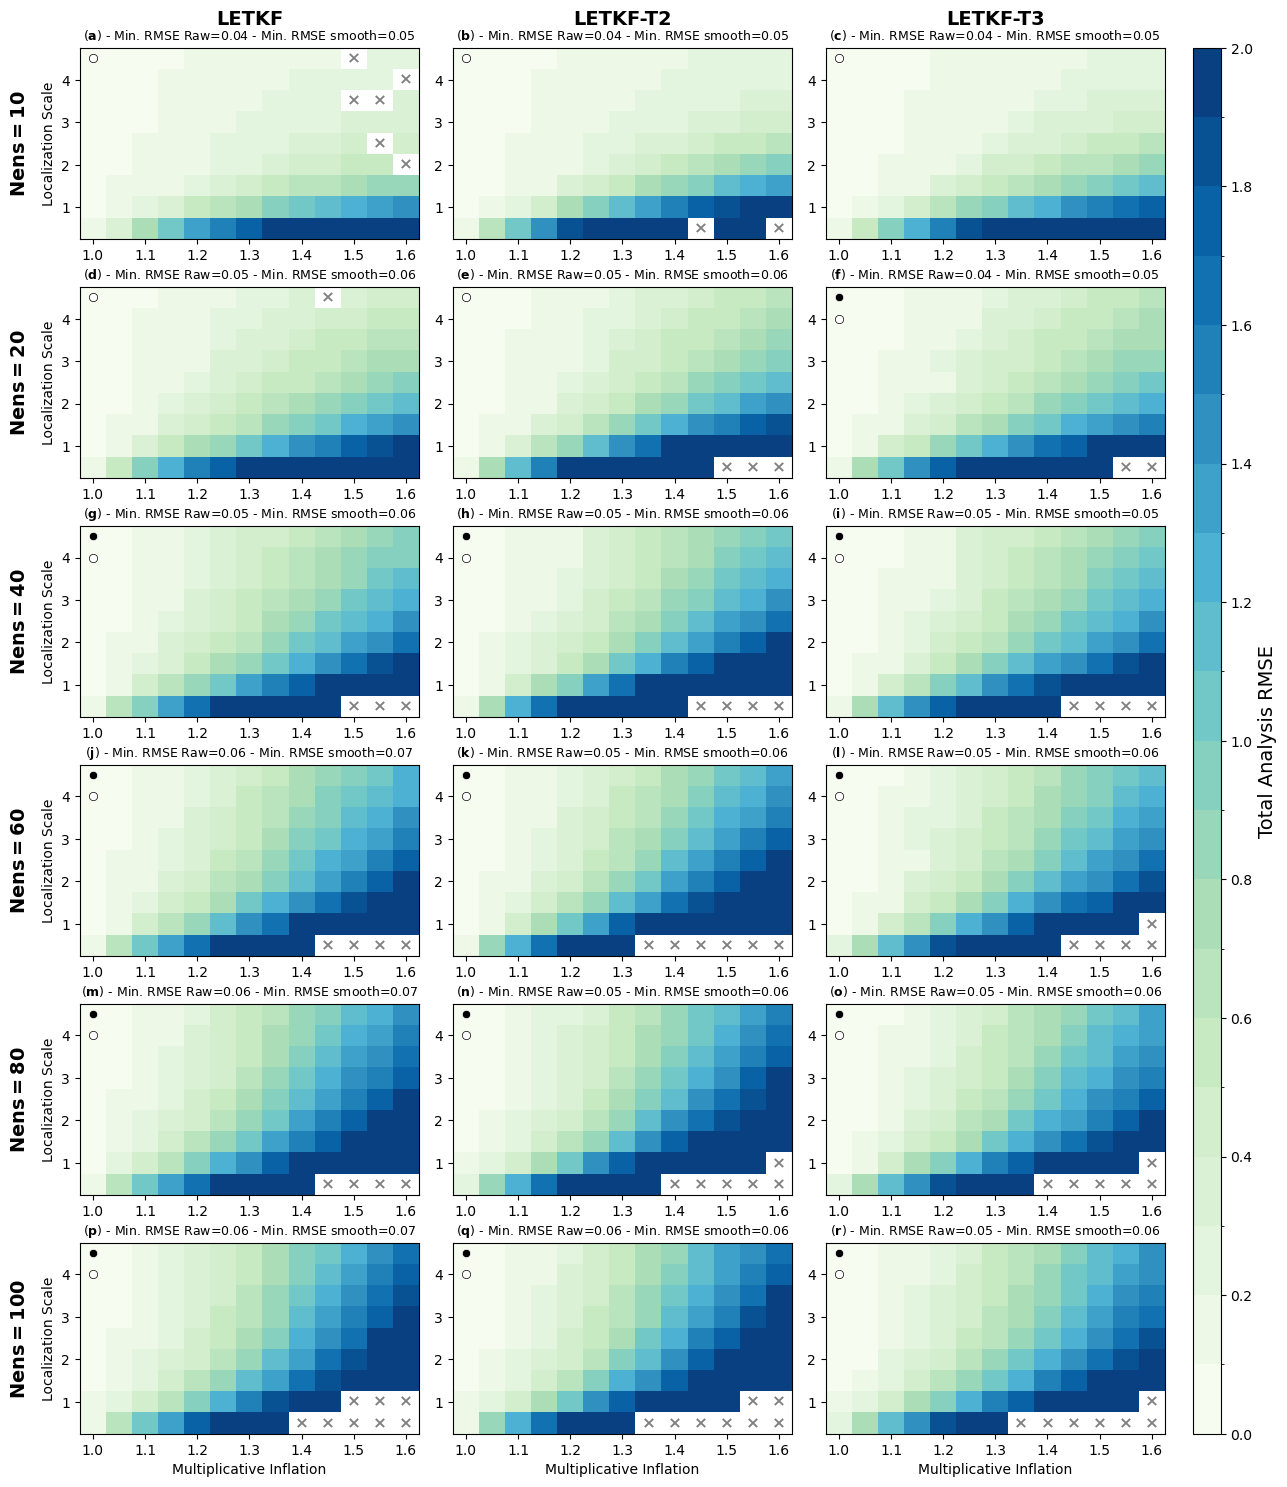

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import common_function as cf
import matplotlib.colors as mcolors
# Configuración
ntemps = [1, 2, 3]
labels = ['LETKF', 'LETKF-T2', 'LETKF-T3']
nens = [10, 20, 40, 60, 80, 100]

freq = 4
den = 1.0
alpha = 2
ObseErr = '5'
gec = 'NOGEC'
fig, axes = plt.subplots(len(nens), len(ntemps), figsize=(14, 18), 
                         sharex=False, sharey=False, 
                         gridspec_kw={'hspace': 0.25, 'wspace': 0.1})


cbar_ax = fig.add_axes([0.92, 0.11, 0.02, 0.77])  # x, y, width, height

vmin, vmax = 0, 2
panel_label_counter = 0

for i, nen in enumerate(nens):
    for j, ntemp in enumerate(ntemps):
        filename = f'LETKF_Paper_Nature_Freq{freq}_Den{den}_Type3_ObsErr{ObseErr}_Nens{nen}_NTemp{ntemp}_alpha{alpha}_{gec}.npz'
        filepath = os.path.join(base_path, filename)
        #print(filepath)

        if os.path.exists(filepath):
            data = np.load(filepath, allow_pickle=True)
            #results = data['results']
            mult_inf_range = data['mult_inf_range']
            loc_scale_range = data['loc_scale_range']

            ax = axes[i, j]
            total_analysis_sprd = data['total_analysis_sprd']
            NormalEnd = 1 - data['NormalEnd']
            NormalEnd = NormalEnd.astype(bool)
            total_analysis_sprd[NormalEnd] = np.nan
            ##total_analysis_sprd = cf.outlier_rmse_filter( total_analysis_sprd )

            min_rmse = np.nanmin(total_analysis_sprd)
            idx_min = np.where(total_analysis_sprd == min_rmse)
            best_mult_inf = mult_inf_range[idx_min[0][0]]
            best_loc_scale = loc_scale_range[idx_min[1][0]]

            total_analysis_sprd_smooth = smooth_filter(total_analysis_sprd, size=5)
            
            min_rmse_smooth = np.nanmin(total_analysis_sprd_smooth)
            idx_min_smooth = np.where(total_analysis_sprd_smooth == min_rmse_smooth)
            best_mult_inf_smooth = mult_inf_range[idx_min_smooth[0][0]]
            best_loc_scale_smooth = loc_scale_range[idx_min_smooth[1][0]]

            #im = ax.pcolormesh(mult_inf_range, loc_scale_range, total_analysis_sprd.T, 
            #                    vmin=vmin, vmax=vmax, cmap='PuBu',edgecolors='lightgray',linewidth=0.001)
            levels = np.arange(0, 2.1, 0.1)  # From 0 to 2, step 0.25
            norm = mcolors.BoundaryNorm(boundaries=levels, ncolors=256)

            im = ax.pcolormesh(mult_inf_range, loc_scale_range, total_analysis_sprd.T,
                            cmap='GnBu', norm=norm, edgecolors='lightgray', linewidth=0.001)            
            ax.plot(best_mult_inf, best_loc_scale, 'k.', markersize=12, markeredgecolor='white',markeredgewidth=0.5)
            ax.plot(best_mult_inf_smooth, best_loc_scale_smooth, 'w.', markersize=12, markeredgecolor='black',markeredgewidth=0.5)

            nan_mask = np.isnan(total_analysis_sprd.T)
            for (y, x), is_nan in np.ndenumerate(nan_mask):
                if is_nan:
                    xi = mult_inf_range[x]
                    yi = loc_scale_range[y]
                    ax.text(xi, yi, '×', ha='center', va='center', color='gray', fontsize=12, fontweight='bold')

            panel_label = rf"$\bf{{{chr(97 + panel_label_counter)}}}$"
            ax.set_title(f"({panel_label}) - Min. RMSE Raw={min_rmse:.2f} - Min. RMSE smooth={min_rmse_smooth:.2f}", fontsize=9)
            panel_label_counter += 1

            if j == 0:
                ax.set_ylabel('Localization Scale', fontsize=10)
            if i == len(nens) - 1:
                ax.set_xlabel('Multiplicative Inflation', fontsize=10)

for i, nen in enumerate(nens):
    axes[i, 0].annotate(rf"$\bf{{Nens = {nen}}}$", xy=(-0.15, 0.5), xycoords='axes fraction',
                        rotation=90, va='center', ha='right', fontsize=14, weight='bold')
for j, t in enumerate(ntemps):
    axes[0, j].annotate(labels[j], xy=(0.5, 1.15), xycoords='axes fraction',
                        va='center', ha='center', fontsize=14, weight='bold')
cbar = fig.colorbar(im, cax=cbar_ax,ticks=np.arange(0, 2.2, 0.2))
cbar.set_label('Total Analysis RMSE', fontsize=14)

os.makedirs(output_dir, exist_ok=True)
figname = f"Figure_Ratio_Nens_Sensitivity_Freq{freq}_Den{den}_Type3_PTemp{alpha}_ObsErr{ObseErr}_{gec}"
output_pdf = os.path.join(output_dir, f"{figname}.pdf")
output_png = os.path.join(output_dir, f"{figname}.png")

plt.savefig(output_pdf, dpi=300, bbox_inches='tight', format='pdf')
plt.savefig(output_png, dpi=300, bbox_inches='tight', format='png')
#plt.show()

print(f"Figure saved as: \n PDF: {output_pdf} \n PNG: {output_png}")

Figure saved as: 
 PDF: /home/jorge.gacitua/salidas/L96_multiple_experiments/figures/Figure_Alpha_Sensitivity_Freq4_Den1.0_Type3_nens80_ObsErr5_NOGEC.pdf 
 PNG: /home/jorge.gacitua/salidas/L96_multiple_experiments/figures/Figure_Alpha_Sensitivity_Freq4_Den1.0_Type3_nens80_ObsErr5_NOGEC.png


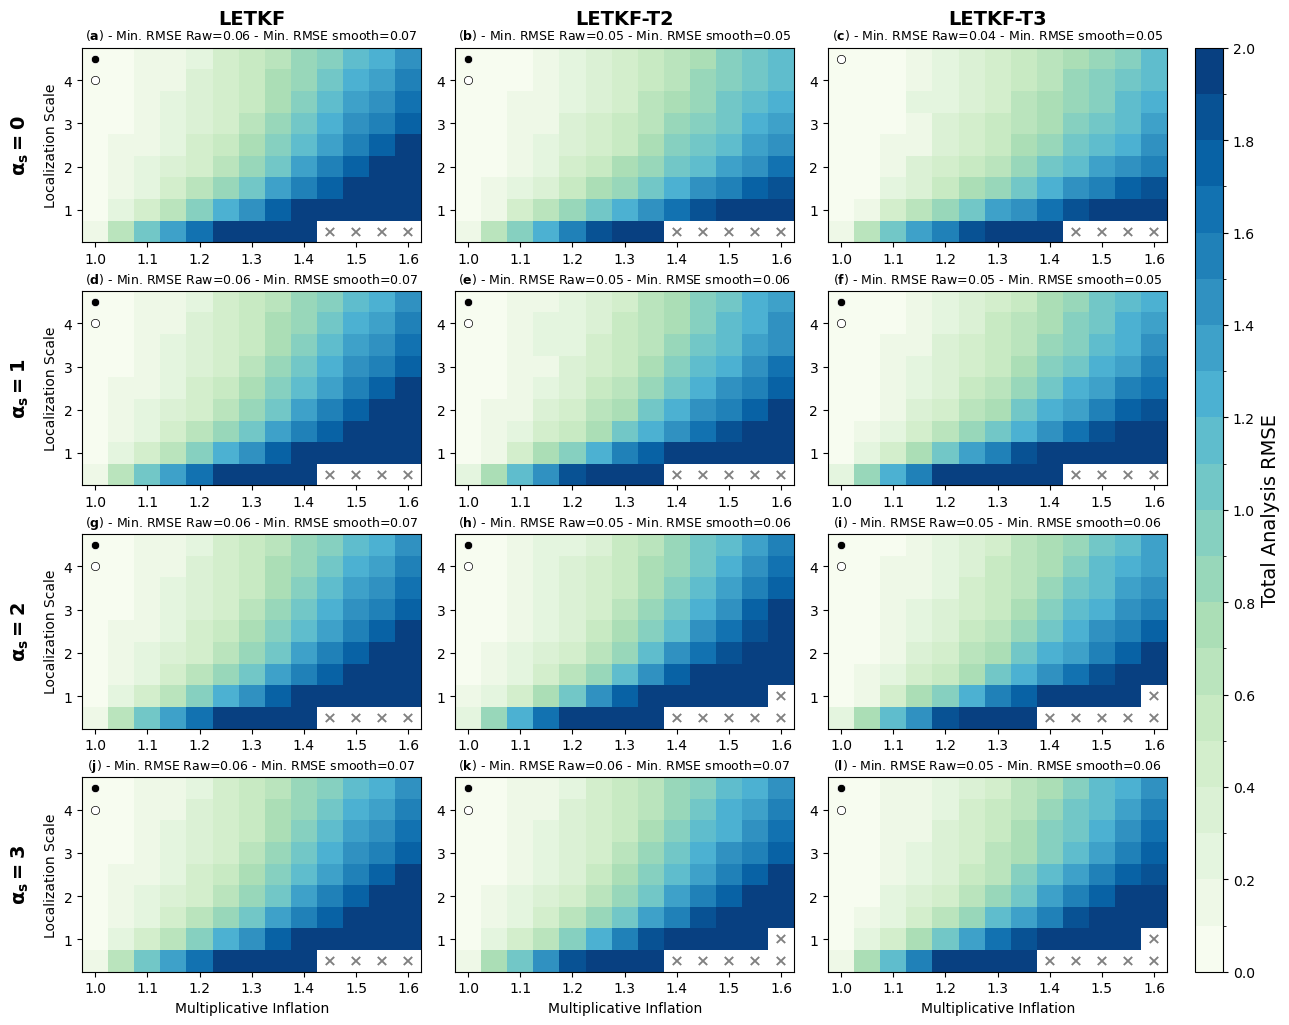

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import common_function as cf
import matplotlib.colors as mcolors
# Configuración

ntemps = [1, 2, 3]
labels = ['LETKF', 'LETKF-T2', 'LETKF-T3']
freq = 4
den = 1.0
alphas = [0,1,2,3]
nen = 80
ObseErr = '5'
gec = '_NOGEC'
fig, axes = plt.subplots(len(alphas), len(ntemps), figsize=(14, 12), 
                         sharex=False, sharey=False, 
                         gridspec_kw={'hspace': 0.25, 'wspace': 0.1})

cbar_ax = fig.add_axes([0.92, 0.11, 0.02, 0.77])  # x, y, width, height
vmin, vmax = 0, 2
panel_label_counter = 0

for i, alpha in enumerate(alphas):
    for j, ntemp in enumerate(ntemps):
        # Load the data
        filename = f'LETKF_Paper_Nature_Freq{freq}_Den{den}_Type3_ObsErr{ObseErr}_Nens{nen}_NTemp{ntemp}_alpha{alpha}{gec}.npz'
        filepath = os.path.join(base_path, filename)
        #print(filepath)
        # Check if the file exists
        if os.path.exists(filepath):
            ax = axes[i, j]
            data = np.load(filepath, allow_pickle=True)
            mult_inf_range = data['mult_inf_range']
            loc_scale_range = data['loc_scale_range']
            total_analysis_sprd = data['total_analysis_sprd']

            NormalEnd = 1 - data['NormalEnd']
            NormalEnd = NormalEnd.astype(bool)
            total_analysis_sprd[NormalEnd] = np.nan

            min_rmse = np.nanmin(total_analysis_sprd)
            idx_min = np.where(total_analysis_sprd == min_rmse)
            best_mult_inf = mult_inf_range[idx_min[0][0]]
            best_loc_scale = loc_scale_range[idx_min[1][0]]

            total_analysis_sprd_smooth = smooth_filter(total_analysis_sprd, size=5)
            
            min_rmse_smooth = np.nanmin(total_analysis_sprd_smooth)
            idx_min_smooth = np.where(total_analysis_sprd_smooth == min_rmse_smooth)
            best_mult_inf_smooth = mult_inf_range[idx_min_smooth[0][0]]
            best_loc_scale_smooth = loc_scale_range[idx_min_smooth[1][0]]

            #im = ax.pcolormesh(mult_inf_range, loc_scale_range, total_analysis_sprd.T, 
            #                    vmin=vmin, vmax=vmax, cmap='PuBu',edgecolors='lightgray',linewidth=0.001)
            levels = np.arange(0, 2.1, 0.1)  # From 0 to 2, step 0.25
            norm = mcolors.BoundaryNorm(boundaries=levels, ncolors=256)

            im = ax.pcolormesh(mult_inf_range, loc_scale_range, total_analysis_sprd.T,
                            cmap='GnBu', norm=norm, edgecolors='lightgray', linewidth=0.001)            
            ax.plot(best_mult_inf, best_loc_scale, 'k.', markersize=12, markeredgecolor='white',markeredgewidth=0.5)
            ax.plot(best_mult_inf_smooth, best_loc_scale_smooth, 'w.', markersize=12, markeredgecolor='black',markeredgewidth=0.5)
            
            nan_mask = np.isnan(total_analysis_sprd.T)
            for (y, x), is_nan in np.ndenumerate(nan_mask):
                if is_nan:
                    xi = mult_inf_range[x]
                    yi = loc_scale_range[y]
                    ax.text(xi, yi, '×', ha='center', va='center', color='gray', fontsize=12, fontweight='bold')

            panel_label = rf"$\bf{{{chr(97 + panel_label_counter)}}}$"
            ax.set_title(f"({panel_label}) - Min. RMSE Raw={min_rmse:.2f} - Min. RMSE smooth={min_rmse_smooth:.2f}", fontsize=9)
            panel_label_counter += 1

            if j == 0:
                ax.set_ylabel('Localization Scale', fontsize=10)
            if i == len(alphas) - 1:
                ax.set_xlabel('Multiplicative Inflation', fontsize=10)

for i, alpha in enumerate(alphas):
    axes[i, 0].annotate(rf"$\bf{{\alpha_s = {alpha}}}$", xy=(-0.15, 0.5), xycoords='axes fraction',
                        rotation=90, va='center', ha='right', fontsize=14, weight='bold')
for j, t in enumerate(ntemps):
    axes[0, j].annotate(labels[j], xy=(0.5, 1.15), xycoords='axes fraction',
                        va='center', ha='center', fontsize=14, weight='bold')
cbar = fig.colorbar(im, cax=cbar_ax,ticks=np.arange(0, 2.2, 0.2))
cbar.set_label('Total Analysis RMSE', fontsize=14)

os.makedirs(output_dir, exist_ok=True)
figname = f"Figure_Alpha_Sensitivity_Freq{freq}_Den{den}_Type3_nens{nen}_ObsErr{ObseErr}{gec}"
output_pdf = os.path.join(output_dir, f"{figname}.pdf")
output_png = os.path.join(output_dir, f"{figname}.png")

plt.savefig(output_pdf, dpi=300, bbox_inches='tight', format='pdf')
plt.savefig(output_png, dpi=300, bbox_inches='tight', format='png')
#plt.show()

print(f"Figure saved as: \n PDF: {output_pdf} \n PNG: {output_png}")

In [ ]:
Freq = 4
Den = 1.0
ObseErr = '5'
nens_labels = np.array([10, 20, 40, 60, 80,100])
alpha_range = np.array([0, 1, 2, 3])
n_alpha = len(alpha_range)
n_nens = len(nens_labels)
best_inflation = np.empty((n_nens, n_alpha, 3))  # 3 methods: LETKF, T2, T3
best_localization = np.empty((n_nens, n_alpha, 3))
rmse_values = np.empty((n_nens, n_alpha, 3))  # 3 methods: LETKF, T2, T3


for k, method_idx in enumerate([0, 1, 2]):  # LETKF, T2, T3
    for iens, nens in enumerate(nens_labels):
        for ialpha, alpha in enumerate(alpha_range):
            filename = f"LETKF_Paper_Nature_Freq{Freq}_Den{Den}_Type3_ObsErr{ObseErr}_Nens{nens}_NTemp{method_idx+1}_alpha{alpha}_NOGEC.npz"
            filepath = os.path.join(base_path, filename)

            if os.path.exists(filepath):
                data = np.load(filepath, allow_pickle=True)
                rmse = data['total_analysis_rmse']
                sprd = data['total_analysis_sprd']
                NormalEnd = 1 - data['NormalEnd']
                NormalEnd = NormalEnd.astype(bool)
                rmse[NormalEnd] = np.nan
                sprd[NormalEnd] = np.nan
                rmse = cf.outlier_rmse_filter(rmse)

                # Apply smoothing
                rmse_smooth = smooth_filter(rmse, size=5)
                sprd_smooth = smooth_filter(sprd, size=5)
                ratio = rmse_smooth/ sprd_smooth
                
                min_idx = np.nanargmin(ratio)
                inf_idx, loc_idx = np.unravel_index(min_idx, ratio.shape)

                best_inflation[iens, ialpha, k] = data['mult_inf_range'][inf_idx]
                best_localization[iens, ialpha, k] = data['loc_scale_range'][loc_idx]
                rmse_values[iens, ialpha, k] = np.nanmin(rmse_smooth)
            else:
                best_inflation[iens, ialpha, k] = np.nan
                best_localization[iens, ialpha, k] = np.nan
                rmse_values[iens, ialpha, k] = np.nan
np.savez(os.path.join(base_path, f"rmse_values_smooth_Freq{Freq}_Den{Den}_ObsErr{ObseErr}_percentage.npz"),
            rmse_values=rmse_values,loc_inflation=best_inflation, loc_scale=best_localization, nens_labels=nens_labels, alpha_range=alpha_range)
print("Data saved successfully.")


Data saved successfully.


Figure saved as: 
 PDF: /home/jorge.gacitua/salidas/L96_multiple_experiments/figures/Figure_Alpha_nens_Sensitivity_Freq4_Den1.0_Type3_nens_ObsErr5_NOGEC.pdf 
 PNG: /home/jorge.gacitua/salidas/L96_multiple_experiments/figures/Figure_Alpha_nens_Sensitivity_Freq4_Den1.0_Type3_nens_ObsErr5_NOGEC.png


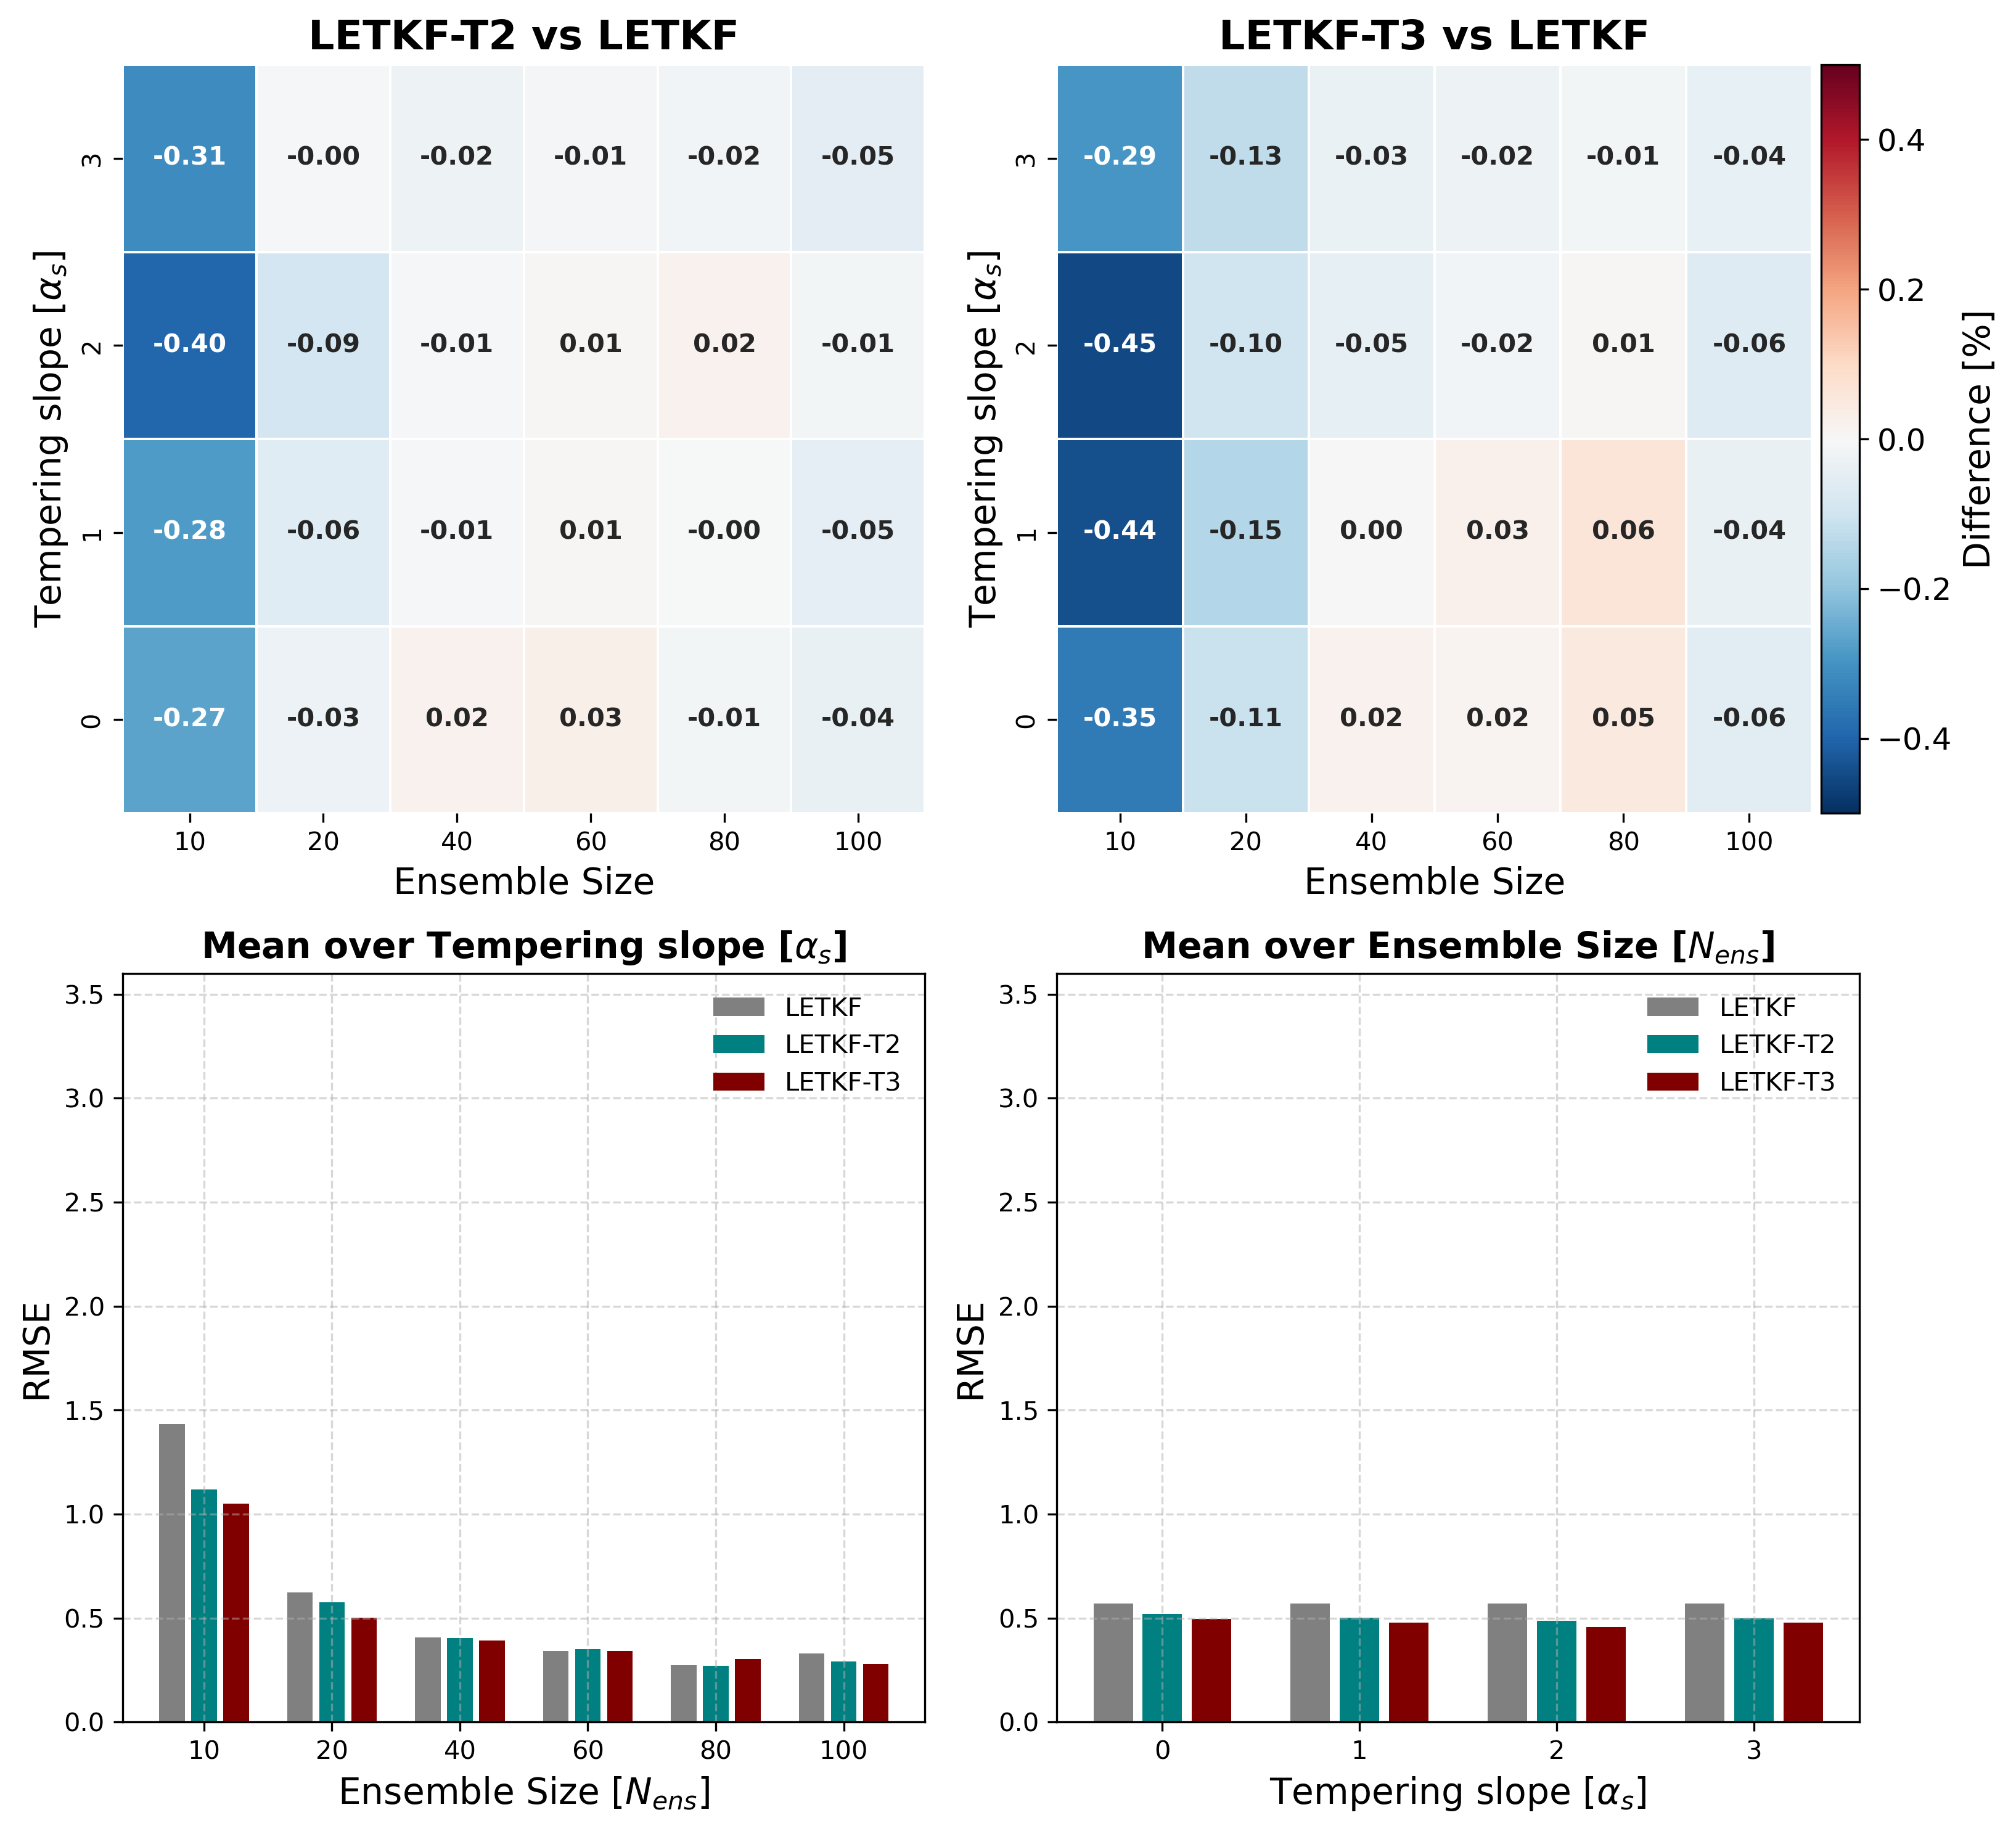

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
import common_function as cf

Freq = 4
Den = 1.0
ObseErr = 5


filename = f'rmse_values_smooth_Freq{Freq}_Den{Den}_ObsErr{ObseErr}.npz'
rmse_values_smooth = np.load(os.path.join(base_path, filename))['rmse_values']

# Assume you already loaded rmse_values_smooth: [n_ens, n_alpha, n_temp]
nens_labels = np.array([10, 20, 40, 60,80,100])
alpha_range = np.array([0, 1, 2, 3])

# Extract LETKF (n_temp = 0), LETKF-T2 (n_temp = 1), LETKF-T3 (n_temp = 2)
letkf      = rmse_values_smooth[:, :, 0]  # shape: (nens, alpha)
letkf_t2   = rmse_values_smooth[:, :, 1]
letkf_t3   = rmse_values_smooth[:, :, 2]

# Calculate % change relative to LETKF
#pct_t2 = ((letkf_t2 - letkf) / letkf) * 100
#pct_t3 = ((letkf_t3 - letkf) / letkf) * 100
pct_t2 = (letkf_t2 - letkf)
pct_t3 = (letkf_t3 - letkf)
# Set up 3-panel figure
fig, axes = plt.subplots(2, 2, figsize=(11, 10), dpi=300)
axes = axes.flatten()  # Flatten to easily index panels

# Panel 1 – LETKF baseline (as horizontal bar since values are alpha-independent)
mean_rmse_letkf = np.mean(letkf, axis=1)  # Take mean across alpha
mean_rmse_letkf_t2 = np.mean(letkf_t2, axis=1)  # Take mean across alpha
mean_rmse_letkf_t3 = np.mean(letkf_t3, axis=1)  # Take mean across alpha
axes[2].grid(True, linestyle='--', alpha=0.5)
axes[2].bar(np.arange(len(nens_labels))*4, mean_rmse_letkf, color='gray',label='LETKF')
axes[2].bar(np.arange(len(nens_labels))*4+1, mean_rmse_letkf_t2, color='Teal',label='LETKF-T2')
axes[2].bar(np.arange(len(nens_labels))*4+2, mean_rmse_letkf_t3, color='Maroon',label='LETKF-T3')
axes[2].set_xticks(np.arange(len(nens_labels))*4+1)
axes[2].set_xticklabels(nens_labels)
#axes[0].invert_yaxis()
axes[2].set_ylabel("RMSE", fontsize=14)
axes[2].set_title(r"Mean over Tempering slope [$\alpha_s$]", fontsize=14, fontweight='bold')
axes[2].set_xlabel(r"Ensemble Size [$N_{ens}$]", fontsize=14)
axes[2].set_ylim(0, 3.6)
axes[2].legend(loc='upper right', fontsize=10, frameon=False)


# Panel 2 – LETKF baseline (as horizontal bar since values are alpha-independent)
mean_rmse_letkf = np.mean(letkf, axis=0)  # Take mean across alpha
mean_rmse_letkf_t2 = np.mean(letkf_t2, axis=0)  # Take mean across alpha
mean_rmse_letkf_t3 = np.mean(letkf_t3, axis=0)  # Take mean across alpha
axes[3].grid(True, linestyle='--', alpha=0.5)
axes[3].bar(np.arange(len(alpha_range))*4, mean_rmse_letkf, color='gray',label='LETKF')
axes[3].bar(np.arange(len(alpha_range))*4+1, mean_rmse_letkf_t2, color='Teal',label='LETKF-T2')
axes[3].bar(np.arange(len(alpha_range))*4+2, mean_rmse_letkf_t3, color='Maroon',label='LETKF-T3')
axes[3].set_xticks(np.arange(len(alpha_range))*4+1)
axes[3].set_xticklabels(alpha_range)
#axes[0].invert_yaxis()
axes[3].set_ylabel("RMSE", fontsize=14)
axes[3].set_title(r"Mean over Ensemble Size [$N_{ens}$]", fontsize=14, fontweight='bold')
axes[3].set_xlabel(r"Tempering slope [$\alpha_s$]", fontsize=14)
axes[3].set_ylim(0, 3.6)
axes[3].legend(loc='upper right', fontsize=10, frameon=False)

# Common settings for heatmaps
vmin, vmax = -0.5, 0.5 

# Panel 3 – % change LETKF-T2 vs LETKF
hm_t2=sns.heatmap(pct_t2.T, annot=True, fmt=".2f", cmap="RdBu_r", center=0,
            vmin=vmin, vmax=vmax, xticklabels=nens_labels, yticklabels=alpha_range,
            ax=axes[0], cbar=False,cbar_kws={"label": "Difference [%]"}, linewidth=.5, annot_kws={"fontsize": 10,"fontweight": "bold"})
#hm_t2.collections[0].colorbar.ax.yaxis.label.set_size(14)   # Colorbar label
axes[0].set_title("LETKF-T2 vs LETKF", fontsize=16, fontweight='bold')
axes[0].set_xlabel("Ensemble Size", fontsize=14)
axes[0].set_ylabel(r"Tempering slope [$\alpha_s$]", fontsize=14)
axes[0].invert_yaxis()
# Panel 4 – % change LETKF-T3 vs LETKF
hm_t3=sns.heatmap(pct_t3.T, annot=True, fmt=".2f", cmap="RdBu_r", center=0,
            vmin=vmin, vmax=vmax, xticklabels=nens_labels, yticklabels=alpha_range,
            ax=axes[1],cbar=False, cbar_kws={"label": "Difference [%]"}, linewidth=.5, annot_kws={"fontsize": 10,"fontweight": "bold"})
#hm_t3.collections[0].colorbar.ax.yaxis.label.set_size(14)   # Colorbar label
axes[1].set_title("LETKF-T3 vs LETKF", fontsize=16, fontweight='bold')
axes[1].set_xlabel("Ensemble Size", fontsize=14)
axes[1].set_ylabel(r"Tempering slope [$\alpha_s$]", fontsize=14)
axes[1].invert_yaxis()
# Layout adjustment
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Use a divider to create a new axis for the colorbar
divider = make_axes_locatable(axes[1])
cax = divider.append_axes("right", size="5%", pad=0.05)

# Add colorbar to the new axis using one of the heatmap mappables
cbar = fig.colorbar(hm_t3.collections[0], cax=cax)
cbar.set_label("Difference [%]", fontsize=14)
cbar.ax.tick_params(labelsize=12)

plt.tight_layout()
os.makedirs(output_dir, exist_ok=True)
figname = f"Figure_Alpha_nens_Sensitivity_Freq{freq}_Den{Den}_Type3_nens_ObsErr{ObseErr}{gec}"
output_pdf = os.path.join(output_dir, f"{figname}.pdf")
output_png = os.path.join(output_dir, f"{figname}.png")

plt.savefig(output_pdf, dpi=300, bbox_inches='tight', format='pdf')
plt.savefig(output_png, dpi=300, bbox_inches='tight', format='png')
#plt.show()

print(f"Figure saved as: \n PDF: {output_pdf} \n PNG: {output_png}")
plt.show()
